# Visualize the gas network simulation results

This notebook shows how to extract topographical and topoloigical data (gas network layout) and related simulation results (mass flow rates in pipes) from the 3DCityDB and visualize this data.

## Define connection parameters for database

First, we define the connection parameters for the 3DCityDB:

In [1]:
from dblayer import *

connect = PostgreSQLConnectionInfo(
    user = 'postgres',
    pwd = 'postgres',
    host = 'localhost',
    port = '5432',
    dbname = 'citydb'
    )

## Retrieving the simulation model 

For visualizing the gas network layout, we will use functionality provided by [PandaNGas](https://github.com/IntegrCiTy/PandaNGas).
Like in the previous notebooks, we can use class *PandaNGasModelDBReader* to retrieve the gas network model:

In [2]:
from dblayer.sim.pandangas import *

pg_reader = PandaNGasModelDBReader( connect )

net = pg_reader.get_net( network_id = 3000 )

After generetaing the model, we can take a quick peek at the model:

In [3]:
net

This pandangas network includes the following parameter tables:
   - pipe (287 elements)
   - load (123 elements)
   - bus (277 elements)
   - feeder (2 elements)

## Extract results for individual pipes

Now let's retrieve the simulation results we have previously stored to the database.
Start by connecting to the 3DCityDB:

In [4]:
db_access = DBAccess()
db_access.connect_to_citydb(connect)

Now we can retrieve all the pipe and associated data. To do so, we can make the following query:
1. Retrieve objects oy type *RoundPipe* that belong to the correct network.
2. Retrieve the correct *Scenario* object that links all the simulation results.
3. Retrieve objects of type *ScenarioParameterTimeSeries* that belong to the correct *Scenarion* as well as to the pipes of the network.

Once you know how the data is linked in the 3DCityDB, you can use [package dblayer](https://github.com/IntegrCiTy/dblayer) to retrieve this data.
A lot of relevant information from separate tables is already joind in *views*, and can be retrieved directly.
But beyond that, the user has to define queries that connect entries via relations of their attributes.
The following lines show how such a complex database query can be defined, joining conditions over several database tables and views.

Like in the previous notebooks, we again start by retrieving the definitions of the data types that we want to work with:

In [5]:
# Get definition of type "RoundPipe" from view "utn9_ntw_feat_distrib_elem_pipe_round". 
RoundPipe = db_access.map_citydb_object_class( 
    'RoundPipe', 
    table_name='utn9_ntw_feat_distrib_elem_pipe_round', schema='citydb_view' 
)

# Get definition of linking between objects of type "NetworkFeature" to objects 
# of type "Network" from table "utn9_network_to_network_feature". 
# This linking has no official name, so we call it "NetworkToFeature".
NetworkToFeature = db_access.map_citydb_object_class( 
    'NetworkToFeature',
    table_name='utn9_network_to_network_feature', schema='citydb', user_defined = True
)

# Get definition of type "Scenario" from view "scn2_scenario". 
Scenario = db_access.map_citydb_object_class( 
    'Scenario',
    table_name='scn2_scenario', schema='citydb_view'
)

# Get definition of linking between scenarios and time series from view "scn2_scenario_parameter_ts". 
# This linking has no official name, so we call it "ScenarioParameterTimeSeries".
ScenarioParameterTimeSeries = db_access.map_citydb_object_class( 
    'ScenarioParameterTimeSeries',
    table_name='scn2_scenario_parameter_ts', schema='citydb_view', user_defined = True
)

Now let's make the actualy query:

In [6]:
pipes_db_data = db_access.join_citydb_objects(
    # Only retrieve data of related to "RoundPipe" and "ScenarioParameterTimeSeries".
    [ 'RoundPipe', 'ScenarioParameterTimeSeries' ],
    # Define the logical relations between all these types and their attributes.
    conditions = [
        NetworkToFeature.network_id == 3000,
        Scenario.name == 'GasGridSimResults',
        RoundPipe.id == NetworkToFeature.network_feature_id,
        ScenarioParameterTimeSeries.cityobject_id == RoundPipe.id,
        Scenario.id == ScenarioParameterTimeSeries.scenario_id
        ]
    )

## Visualizing the simulation results

We have gathered all the relevant data from the database and can use it now for a visualization.
In this example, we will use [matplotlib](https://matplotlib.org/) and [imageio](https://imageio.readthedocs.io/en/stable/) to render an animation of the mass flow rates in the pipes.

First, we exract and slightly transform the data to a format that is useful for further processing:

In [7]:
from math import *

# Store results in this dict for further processing.
pipes_m_dot = {}

# Iterate through query results.
for data in pipes_db_data:
    
    # Retrieve pipes and corresponding time series data.
    pipe = data[0]
    scenario_param_ts = data[1]
    
    # Use logarithmic representation of data for better visibility.
    pipes_m_dot[pipe.name] = [ log1p( fabs( float(val) ) ) for val in scenario_param_ts.ts_values_array ]

Next, retrieve the start time, time interval and time unit of the time series data.
Since this is the same for all, we retrieve it simply from the first results entry:

In [8]:
time_start = pipes_db_data[0][1].ts_temporal_extent_begin
time_interval = int( pipes_db_data[0][1].ts_time_interval )
time_unit = pipes_db_data[0][1].ts_time_interval_unit

Use functionaliyt from PandaNGas to retrieve the network layout (as [networkx](https://networkx.org/) graph) from the simulation model:

In [9]:
from pandangas.topology import create_nxgraph

g = create_nxgraph( net ).to_undirected()

Retrieve the positions of the network nodes from the graph:

In [10]:
nodes_pos = { n.name: pg_reader.geom_to_point2d( n.geom ).list() for n in pg_reader.network_nodes }
nodes_pos_x = [ p[0] for n, p in nodes_pos.items() ]
nodes_pos_y = [ p[1] for n, p in nodes_pos.items() ]

Define a helper function for retrieving the name of a pipe connecting two nodes from the name of the nodes:

In [11]:
def get_pipe_name( node_name1, node_name2 ):
    node_id1_str = node_name1[8:]
    node_id2_str = node_name2[8:]
    
    if int( node_id1_str ) < int( node_id2_str ):
        return 'gas_pipe{}-{}'.format( node_id1_str, node_id2_str )
    else:
        return 'gas_pipe{}-{}'.format( node_id2_str, node_id1_str )

Import all the additional packages that are required for the visualization:

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import imageio
from pytimeparse.timeparse import timeparse
from datetime import timedelta

The following function extracts a static figure for each *frame*. These frames will afterwards be joined to an animation:

In [13]:
def animate_pipes_m_dot(figure, i):
    figure.clear()

    # Define subtitle of figure (shows the simulation time).
    time_delta = timedelta( seconds = timeparse( '{delta}{unit}'.format( delta=i*time_interval, unit=time_unit ) ) )
    figure.suptitle( str( time_start + time_delta ) )
    
    # The pipes (i.e., the edges of the graph) are colored according to the value of the mass flow rate.
    edge_color_list = [ pipes_m_dot[ get_pipe_name(e[0],e[1]) ][i] for e in g.edges ]
    # Draw the networkx graph, using the previously defined color list for the edges.
    nx.draw( g, nodes_pos, edge_color=edge_color_list, edge_cmap=plt.cm.coolwarm, edge_vmin=0, edge_vmax=0.02, width=1, node_size=15 )

    # Draw the figure for this frame.
    figure.canvas.draw()
    w, h = figure.canvas.get_width_height()

    # Convert this figure to a useful format and return it.
    image_array = np.frombuffer( figure.canvas.tostring_rgb(), dtype='uint8' )
    return image_array.reshape( ( h, w, 3 ) )

Use matplotlib and imagio to create an animated GIF from the animation function:

In [14]:
%%capture

fig, ax = plt.subplots()
ax.set_xlim( ( min(nodes_pos_x), max(nodes_pos_x) ) )
ax.set_ylim( ( min(nodes_pos_y), max(nodes_pos_y) ) )

imageio.mimsave( './img/pipes_m_dot.gif', [ animate_pipes_m_dot(fig, i) for i in range(3,9) ], fps=2 )

Display the animated GIF in this notebook:

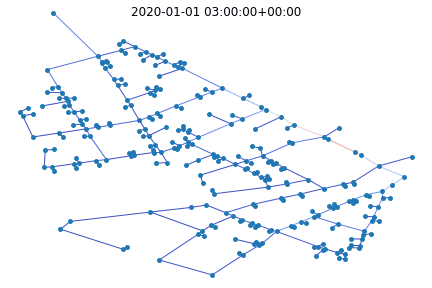

In [15]:
from IPython.display import Image
Image(filename="./img/pipes_m_dot.gif")

Done.